### Working with unlabeled data - GMMs

Instructor: Nedelina Teneva  <br>

Citations: <br>
   - https://towardsdatascience.com/how-to-code-gaussian-mixture-models-from-scratch-in-python-9e7975df5252
   - https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html
   - https://www.kaggle.com/vipulgandhi/gaussian-mixture-models-clustering-explained
   - https://www.dropbox.com/s/y9a7b0hzmuksqar/Chapter9.pdf?dl=0
   - https://pythonmachinelearning.pro/clustering-with-gaussian-mixture-models/
   - Cornelia Ilin's prep material: https://github.com/MIDS-W207/cilin-coursework/tree/master/live_sessions
   
Examples to explore on your own: <br>
  - Spoken Speaker Identification based on Gaussian Mixture Models (https://appliedmachinelearning.blog/2017/11/14/spoken-speaker-identification-based-on-gaussian-mixture-models-python-implementation/)
  - Voice gender detection (https://appliedmachinelearning.blog/2017/06/14/voice-gender-detection-using-gmms-a-python-primer/)

### Objectives:
 - Generative Mixture Models (GMM).
 - Expectation-Maximization (EM).

### The idea behind GMM:
   - based on the assumption that all data points come from a mixture of Gaussian distributions with unknown parameters.
   - a model that tries to learn the data generating process (i.e., the true data distribution (mean, variance and scale parameters).
   - learns these parameters by maximizing the maximum likelihood criterion using the EM algorithm.

Assuming a 1-D data, the maximum likelihood criterion is the weighted sum of several univariate normal distributions:

$f_C = \sum_{j=1}^k \phi_j f_{\mathbf{\mu_j, \;\sigma_j}}$,

where **C are the 1-D data points**, **j = 1,..., k are the number of clusters**, and $\phi_j$ is **the scale parameter** (i.e., the weight each cluster gets in the sum). The parameters $\mu_j, \sigma_j, \phi_j$ are estimated using the EM algorithm.


`Question:` How does the pdf ($f_C$) look in the n-D case?

### K-means vs. GMM:

   - `Similarities:`
   - `Disimilarities:`

### Let's talk about a 1-D example:
 - assume we only have one feature
 - assume the number of clusters, k =2

`Question:` How many parameters will GMM attempt to learn?

Hint:
  - each cluster is represented by a Gaussian distribution (so we will have 2 distributions in total).
  - for each Gaussian, GMM learns one mean, one variane, and one scalling parameter.
  - so how many parameters in total?


`Question:` How does GMM learn these parameters?

### Ready to see a 1-D example at work?

In [1]:
# standard
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt

# machine learning
from scipy.stats import multivariate_normal
from sklearn import cluster, datasets, mixture
from sklearn.mixture import GaussianMixture

### Define the probability density function
pdf(x): for a given sample, pdf() is the likelihood that the random variables x will have the sample value

In [2]:
def gauss_pdf(data, mean:float, variance:float):
    """ estimate probability density function; 1-D gaussian distribution equation
    (see formula here: https://en.wikipedia.org/wiki/Normal_distribution)
    # param data: np.array
    # param mean: float point
    # param variance: float point
    # return probability densitity function, i.e. gauss_pdf: np.array, float points
    """
    s1 = 1/(np.sqrt(2*np.pi*variance))
    s2 = np.exp(-(np.square(data - mean)/(2*variance)))

    # compute pdf
    pdf = s1 * s2

    return pdf

### Synethetic Dataset Creation (random 1-D data points)
By sampling points from K=2 different Gaussian distributions, each with its own mean and variance: $c_k \sim N (\mu, \sigma^2)$

The two Gaussian distributions are:

`cluster 1:`
$f(c|\mu_1, \sigma_1^2) = \frac{1}{\sqrt{2\pi\sigma_1^2}} \exp -\frac{(c-\mu_1)^2}{2\sigma_1^2}$

`cluster 2:`
$f(c|\mu_2, \sigma_2^2) = \frac{1}{\sqrt{2\pi\sigma_2^2}} \exp -\frac{(c-\mu_2)^2}{2\sigma_2^2}$

In [3]:
# define the number of points, mean and variance
n_samples = 100
mu1, sigma1 = -4, 1.2
mu2, sigma2 = 0, 1.6

# generate two clusters drawn from a random normal distribution
c1 = np.random.normal(mu1, np.sqrt(sigma1), n_samples)
c2 = np.random.normal(mu2, np.sqrt(sigma2), n_samples)

# put the two clusters together
C = np.array(list(c1) + list(c2))

# print C
print("Dataset shape:", C.shape)
pd.DataFrame(C).head(10)

Dataset shape: (200,)


,0
0,-4.691347
1,-3.648285
2,-4.036491
3,-2.619520
4,-5.047590
5,-2.758252
6,-4.116258
7,-4.737128
8,-2.738423
9,-3.968732


Let's visualize the data points in each cluster, and the two Gaussian distributions. Notice how some of the values actually overlap!

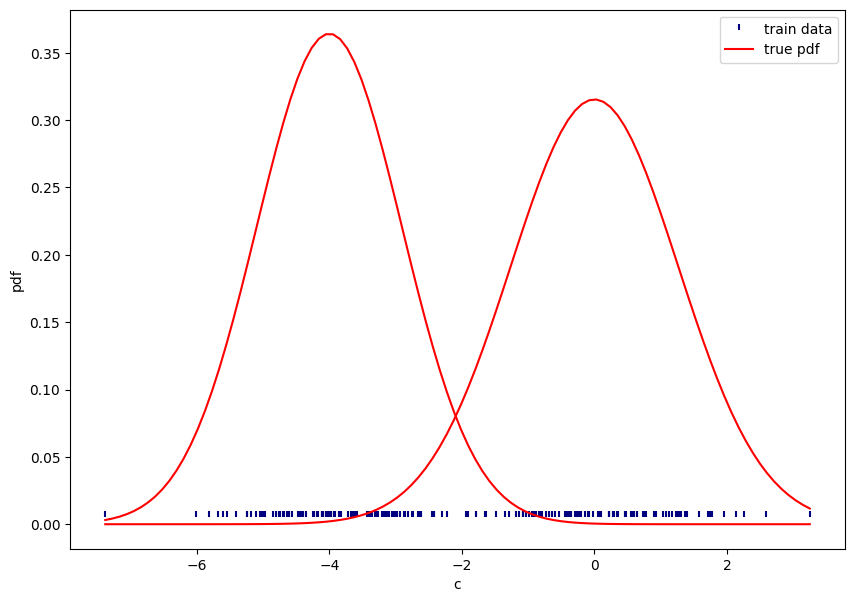

In [4]:
# create bins for X axis (100 points in total, evenly spaced)
bins = np.linspace(np.min(C), np.max(C), 100)

# plot points in C
plt.figure(figsize=(10,7))
plt.scatter(C, [0.005] * len(C), color='navy', s=20, marker=2, label='train data')

# plot distribution for each cluster in C
plt.plot(bins, gauss_pdf(bins, mu1, sigma1), color='red', label='true pdf')
plt.plot(bins, gauss_pdf(bins, mu2, sigma2), color='red')

# add labels, legend
plt.xlabel("c");
plt.ylabel("pdf");
plt.legend();

Let's now use GMMs to learn the 2 clusters (the 2 Gaussian distributions). So what do we need to learn more precisely?

We use the EM algorithm to estimate $\mu_1, \sigma_1^2, \mu_2, \sigma_2^2, \phi_1, \phi_2$.

### Estimate GMM parameters with EM

**The EM algorithm:**

[1] guess initial values for $\mu_1, \sigma_1^2, \mu_2, \sigma_2^2$, and set $\phi_1=\phi_2 = \frac{1}{2}$ (in general it's $\frac{1}{k}$ for each $\phi_j, j \in 1,...,k$).
   
[2] the Expecation (E) step:
   - for all $i=1,...,N$, calculate the likelihood $f(c_i|\mu_j, \; \sigma_j^2)$ for each $i, j$.
   - using Bayes' Rule, for each example $c_i$, calculate the likelihood $b_i^j$ that the example belongs to cluster $j\in\{1,2\}$, i.e. the likelihood that the example was drawn from a Gaussian:
  
    $b_i^j = \frac{f(c_i|\mu_j, \; \sigma_j^2) \phi_j}{f(c_i|\mu_1, \; \sigma_1^2) \phi_1 + f(c_i|\mu_2, \; \sigma_2^2) \phi_2}.$

[3] the Maximization (M) step:
   - compute the new values for $\mu_j, \sigma_j^2, j \in{1,2}$ as:
   
   $\mu_j = \frac{\sum_{i=1}^N b_i^j c_i}{\sum_{i=1}^N b_i^j}$,
   $\sigma_j^2 = \frac{\sum_{i=1}^N (c_i - \mu_j)^2}{\sum_{i=1}^N b_i^j}.$
   - update $\phi_j, j\in{1,2}$ as:
   
   $\phi_j = \frac{1}{N}\sum_{i=1}^N b_i^j.$
   
[4] repeat steps [2-3] until the values $\mu_j$ and $\sigma_j$ don't change much, i.e., the change is below some threshold $\epsilon.$

[5] once we have learned $\mu_j$ and $\sigma_j$ for each cluster $j$, the membership score of example $c_i$ in cluster $j$ is given by $f(c_i|\mu_j, \sigma_j^2).$

#### EM step [1] -- Set initial parameter values

In [5]:
# number of clusters to be learned
k = 2
print('clusters:', k)

# initial phi1 and phi2
weights = np.ones((k)) / k
print('initial weights:', weights)

# initial means
means = np.random.choice(C, k)
print('initial means:', means)

# initial variances
variances = np.random.random_sample(size=k)
print('initial variances:', variances)

clusters: 2
initial weights: [0.5 0.5]
initial means: [1.23867753 0.10537914]
initial variances: [0.85181884 0.2072584 ]


#### EM steps [2] and [3] -- the E and M steps + multiple iterations

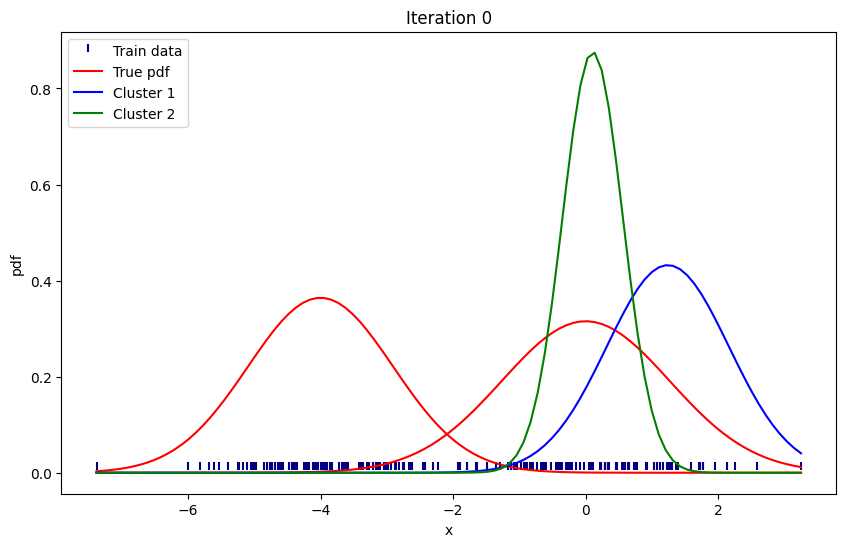

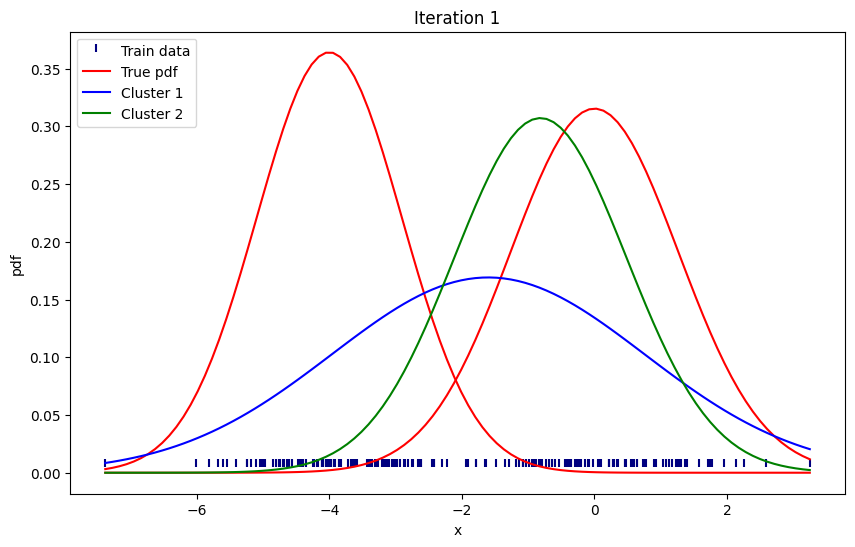

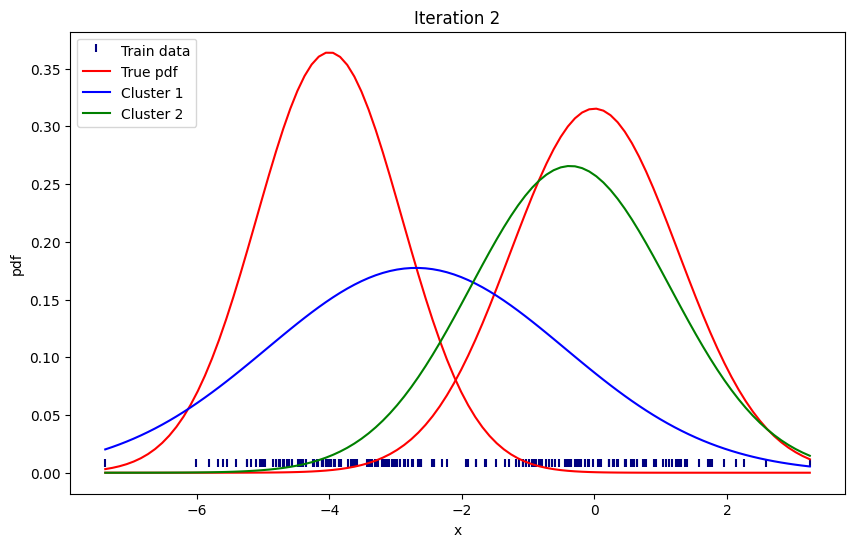

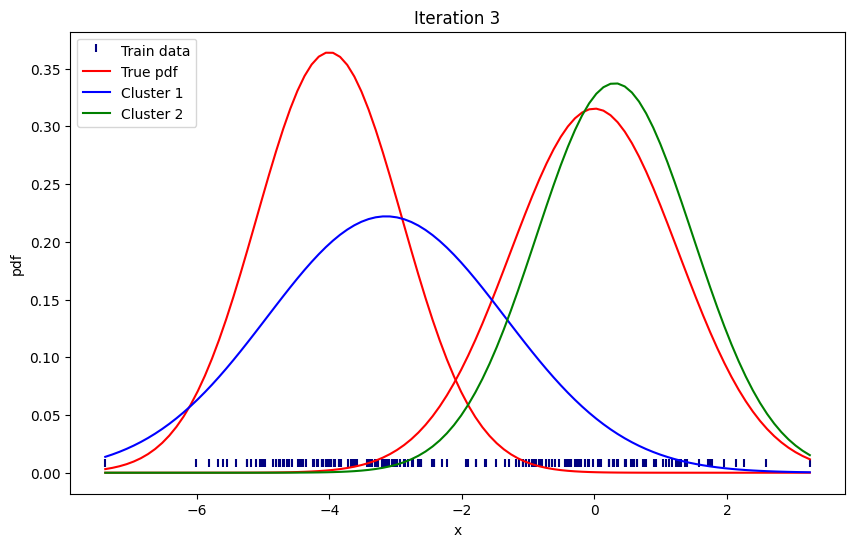

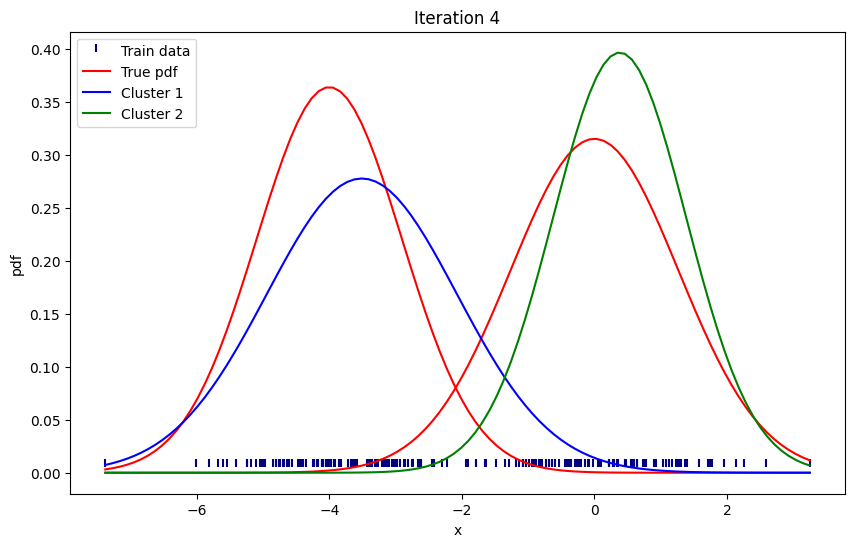

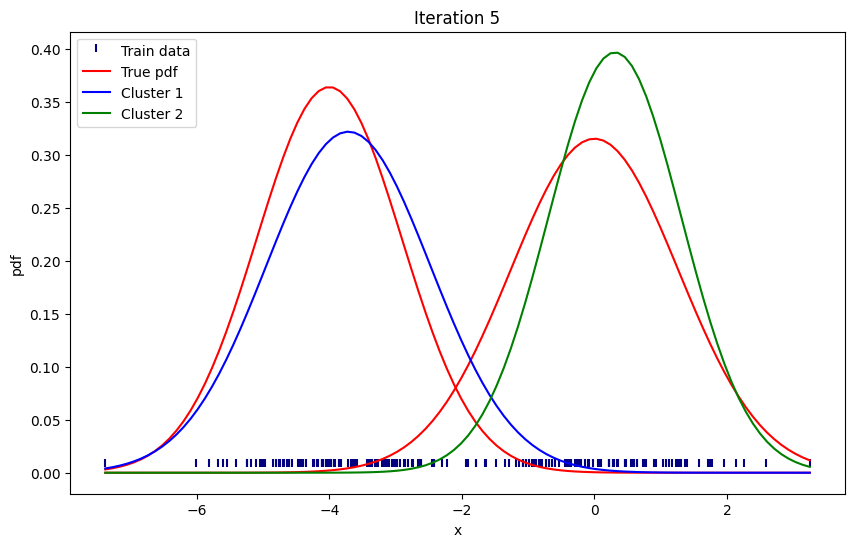

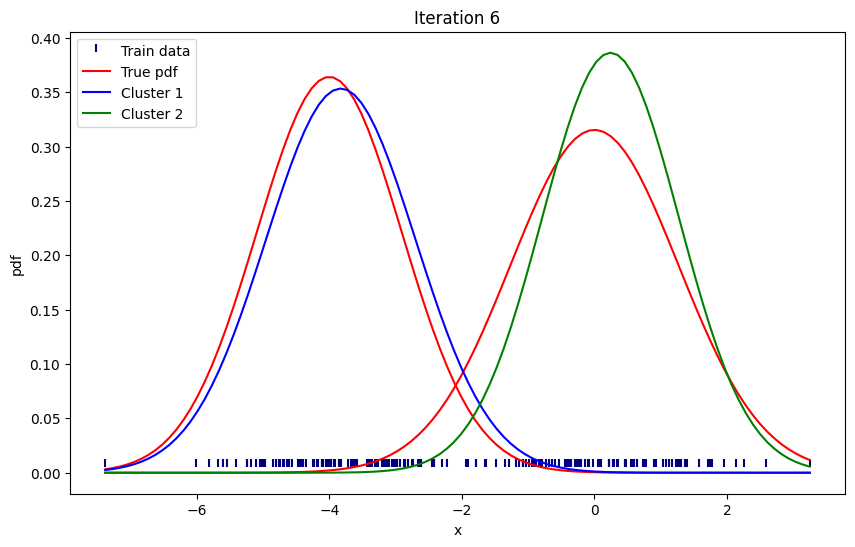

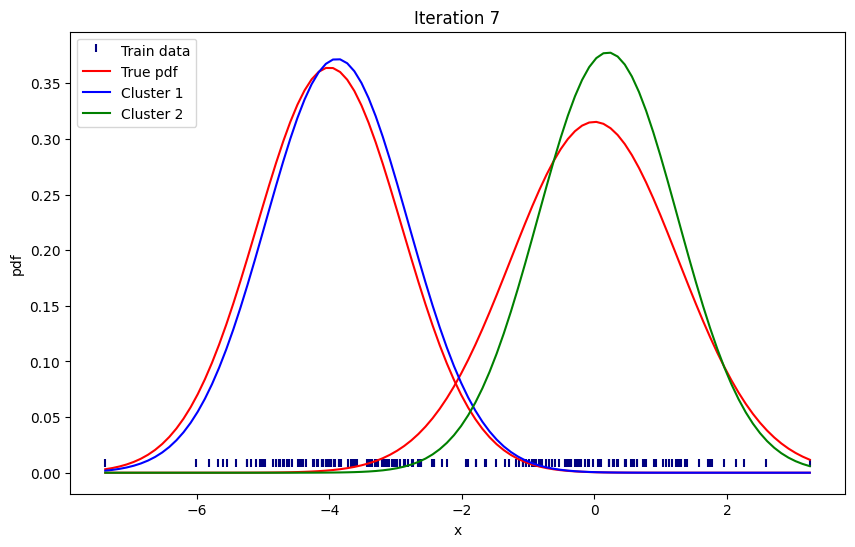

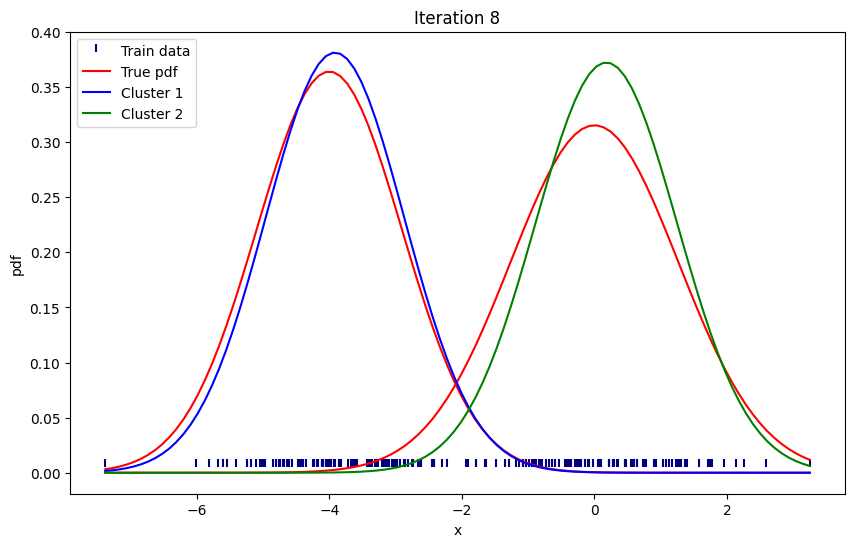

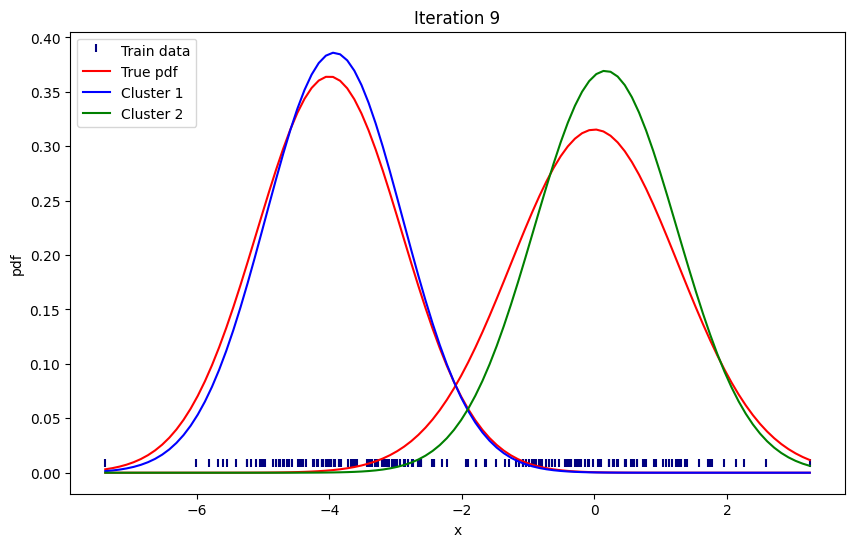

In [6]:
# set epsilon
eps=1e-8

# set number of iterations
for iteration in range(10):

    if iteration % 1 == 0:
        plt.figure(figsize=(10,6))


        # plot C data
        plt.title("Iteration {}".format(iteration))
        plt.scatter(C, [0.005] * len(C), color='navy', s=30, marker=2, label="Train data")

        # plot true pdf
        plt.plot(bins, gauss_pdf(bins, mu1, sigma1), color='red', label="True pdf")
        plt.plot(bins, gauss_pdf(bins, mu2, sigma2), color='red')

        # plot estimated pdf
        plt.plot(bins, gauss_pdf(bins, means[0], variances[0]), color='blue', label="Cluster 1")
        plt.plot(bins, gauss_pdf(bins, means[1], variances[1]), color='green', label="Cluster 2")

        # add labels and legend
        plt.xlabel("x")
        plt.ylabel("pdf")
        plt.legend(loc='upper left')

    ## the Expectation step
    # calculate the likelihood of each observation ci
    likelihood = []

    for j in range(k):
        likelihood.append(gauss_pdf(C, means[j], np.sqrt(variances[j])))
    likelihood = np.array(likelihood)

    # calculate the likelihood that each observation ci belongs to cluster j
    b = []

    for j in range(k):
        # use the current values for the parameters to evaluate the posterior
        # probabilities that the data has been generanted by each of the Gaussians
        b.append((likelihood[j] * weights[j]) / (np.sum([likelihood[i] * weights[i] for i in range(k)], axis=0)+eps))

        ## The Maximization step
        # update mean and variance
        means[j] = np.sum(b[j] * C) / (np.sum(b[j] + eps))
        variances[j] = np.sum(b[j] * np.square(C - means[j])) / (np.sum(b[j] + eps))

        # update the weights
        weights[j] = np.mean(b[j])

#### Visualize the final results

let's visualize the final mean, variance, phi values, and posterior (Bayesian) probabilities

In [7]:
print('means:', means)
print('variances:', variances)
print('weights:', weights)
print('first five posterior_prob:\n', pd.DataFrame((b[0].round(3), b[1].round(3))).T.iloc[:5,:])

means: [-3.93495709  0.16007661]
variances: [1.0560328  1.17686224]
weights: [0.50547967 0.494574  ]
first five posterior_prob:
        0      1
0  1.000  0.000
1  0.999  0.001
2  1.000  0.000
3  0.943  0.057
4  1.000  0.000


posterior_prob represent a matrix of size [n_samples, n_clusters] which measures the probability that any point belongs to the given cluster:

Finally, let's use the GaussianMixture class in the sklearn.mixture module to see if we did a good job implementing GMM manually.

In [8]:
# reshape C in a way that sklearn likes it
C = np.concatenate([c1, c2]).reshape(-1, 1)

# create an instance of the GaussianMixture class; set number of clusters to 2
gmm = GaussianMixture(n_components=2)

# fit the gmm model
gmm.fit(C)

# get the cluster labels
labels = gmm.predict(C)
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1])

In [9]:
print('means:', gmm.means_)
print('\n')
print('variances:', gmm.covariances_)
print('\n')
print('weights:', gmm.weights_)
print('\n')
print('first five posterior_prob:\n', gmm.predict_proba(C)[:5].round(3))

means: [[-3.95897096]
 [ 0.12763571]]


variances: [[[1.02277816]]

 [[1.24224976]]]


weights: [0.49855696 0.50144304]


first five posterior_prob:
 [[1.    0.   ]
 [0.997 0.003]
 [0.999 0.001]
 [0.905 0.095]
 [1.    0.   ]]


Question: do you think our GMM implementation is correct?

### Select the optimal number of components (k)

We can use some analytic criterion such as the Akaike information criterion (AIC) or the Bayesian information criterion (BIC). Scikit-Learn's Gaussian Mixture estimator actually includes built-in methods that compute both of these.

This criterion gives us an estimation on how good the GMM is in terms of predicting the data we actually have. The lower is the BIC or AIC, the better is the model to actually predict the data we have.

In order to avoid overfitting, this technique penalizes models with big number of clusters.

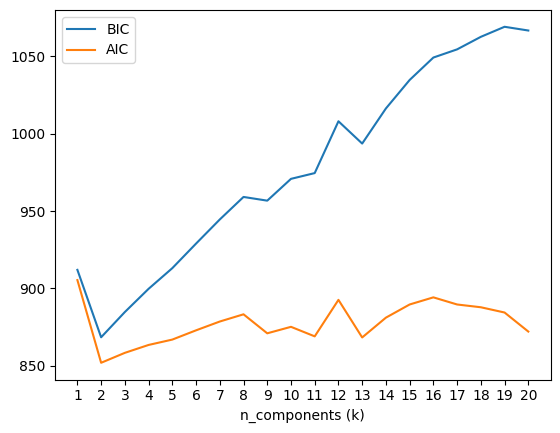

In [10]:
# try for k=1,..., 20
n_components = np.arange(1, 21)

# create instance of the GaussianMixture class and fit the model
gmms = [GaussianMixture(n, covariance_type='full').fit(C)
        for n in n_components]

plt.plot(n_components, [m.bic(C) for m in gmms], label='BIC')
plt.plot(n_components, [m.aic(C) for m in gmms], label='AIC')

plt.legend(loc='best')
plt.xlabel('n_components (k)');
plt.xticks(np.arange(min(n_components), max(n_components)+1, 1.0));

The AIC tells us that our choice of 2 components was the best choice (of course, we engineered the data!). The BIC recommendation is the same, but typically (in higher dimensional spaces), the BIC recommends a simpler model.

**Though GMM is often categorized as a clustering algorithm, fundamentally it is an algorithm for density estimation (!) That is to say, the result of a GMM fit to some data is technically not a clustering model, but a generative probabilistic model describing the distribution of the data.**